In [1]:
!pip install openai
!pip install boto3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.9/220.9 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires tiktoken, which is not installed.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 78.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 9.6 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import openai
import base64
import requests
import json

In [4]:
path = '/content/drive/MyDrive/GPT4_Vision_Product_Tagging'
os.chdir(path)

Images found: 3


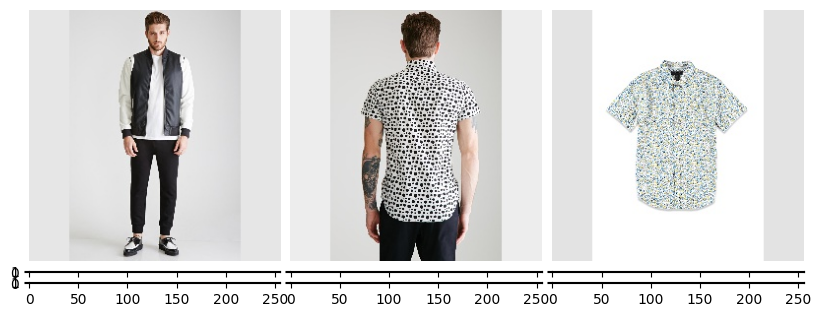

In [5]:
from pathlib import Path
import boto3
from io import BytesIO
import random
from PIL import Image
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid


# Set your AWS credentials (replace 'your_access_key' and 'your_secret_key' with your actual AWS credentials)
aws_access_key_id = 'ACCESS_KEY_ID'
aws_secret_access_key = 'SECRET_ACCESS_KEY'

# Set the S3 bucket and folder path
s3_bucket_name = 'team3-ass3'
s3_folder_path = 'image'

# Create an S3 client
s3_client = boto3.client('s3', aws_access_key_id=aws_access_key_id, aws_secret_access_key=aws_secret_access_key)

# List all JPGs in the S3 folder
images_files = []

response = s3_client.list_objects(Bucket=s3_bucket_name, Prefix=s3_folder_path)
for obj in response.get('Contents', []):
    if obj['Key'].endswith('.jpg'):
        images_files.append(obj['Key'])

selected_images = random.sample(images_files, 3)

# Download images and store them in a list
image_data = []
for image_key in selected_images:
    response = s3_client.get_object(Bucket=s3_bucket_name, Key=image_key)
    image_bytes = response['Body'].read()
    image_data.append(BytesIO(image_bytes))

# Print some statistics
print(f'Images found: {len(image_data)}')

# Display images
rows, columns = (3, 3)
fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111, nrows_ncols=(rows, columns), axes_pad=0.1)

for ax, im_data in zip(grid, image_data[:rows * columns]):
    im = Image.open(im_data)
    ax.imshow(im)
    ax.axis('off')

plt.show()


In [6]:
# Save images to the specified drive path
drive_path = '/content/drive/MyDrive/GPT4_Vision_Product_Tagging/FashionImages'
Path(drive_path).mkdir(parents=True, exist_ok=True)

for i, im_data in enumerate(image_data):
    image = Image.open(im_data)
    if i < 10:
      image_path = f'{drive_path}/image_{i + 1}.jpg'
      image.save(image_path)

# Print some statistics
print(f'Images found: {len(image_data)}')
print(f'Images downloaded to: {drive_path}')

Images found: 3
Images downloaded to: /content/drive/MyDrive/GPT4_Vision_Product_Tagging/FashionImages


In [7]:
# Function to encode a single image
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

In [8]:
openai.api_key = 'OPENAI_API_KEY'

In [9]:
filename = 'fashion_responses.json'

### Function to Save the Response Context of images

In [10]:
def save_response_content(image_name, content):
    data = {
        "image": image_name,
        "response_content": content
    }

    # Check if file exists and has content
    try:
        with open(filename, 'r+') as file:
            # Read current data from file
            file_data = json.load(file)
            # Append new data
            file_data.append(data)
            # Set file's current position at offset
            file.seek(0)
            # Update JSON file
            json.dump(file_data, file, indent=4)
    except (FileNotFoundError, json.JSONDecodeError):
        # Create new file with initial data
        with open(filename, 'w') as file:
            json.dump([data], file, indent=4)



In [11]:
import os
from pathlib import Path


# Image folder path
folder_path = "FashionImages"

# List all files in the folder
image_files = [file for file in Path(folder_path).rglob("*.jpg") if file.is_file()]
print(len(image_files))

# Prepare the payload for each image
payload = []
for image_file in image_files:
    # Encode the image
    base64_image = encode_image(str(image_file))

    # Prepare the image content for the payload
    image_content = {
        "type": "image_url",
        "image_url": {
            "url": f"data:image/jpeg;base64,{base64_image}"
        }
    }
    # Append to the payload list
    payload.append(image_content)


3


In [12]:
print(len(payload))

3


### Creating Prompt for Fashion Dataset

In [13]:
%%writefile prompts.py

postcards = (
    "YOUR ROLE:\n"
    "You are an image tagging expert that works for an online cards company, "
    "your job is to meticulously tag every image given in a lot of detail with "
    "the purpose of using those tags for improved user search and a recommender algorithm\n\n"
    "UNDERSTANDING:\n"
    "First, explain your understanding of what the card is, what point or joke it is "
    "trying to make. Consider any cultural references that might be depicted in the image. "
    "Popular TV shows, movies, cultural events, famous people.\n\n"
    "TAGGING:\n"
    "You need to generate 2 types of tags and output them in a JSON format in a single file. "
    "So to start with, think about what kind of tags would be useful for someone searching for "
    "a card online or to enhance the recommender algorithm.\n\n"
    "1) Title, Description, Cultural reference - Write the title and description of the image. "
    "Then state whether the image has any cultural references (e.g. Popular TV shows, British TV Shows, "
    "Cultural Events) or depicts any famous individuals (e.g. Politicians, Singers, Sports Personalities). "
    "If they are included, then please provide a specific reference (e.g. Name of the TV show) or description "
    "of the type of person included (e.g. a Politician) - include as much specific info as possible.\n\n"
    "2) Image descriptions: generate tags between 10 and 50 tags that describe the image in a useful way. "
    "Include descriptive tags about the image, then think about the tags that would be useful for someone to find "
    "this image or for a recommender algorithm to perform well.\n\n"
    "2) Category tags: there are high level categories for images, you need to first put them into the appropriate "
    "categories they are, and then for each category, you need to list sub-categories (examples given, but you can "
    "come up with more lower level sub-categories) - there could be more than one sub-category:\n"
    "  - How is it for (e.g. for him, for her, auntie...)\n"
    " - Occasion (e.g. birthday, anniversaries...)\n"
    " - Age (e.g. Adult, kids...)\n"
    " - Sentiment & Style (e.g. funny, rude, cheeky...)\n"
    " - Topic (e.g. animals, Interests & hobbies...)\n\n"
    "Please respond in the following format - plaintext explanation of the card, then JSON format below:\n"
    "'[plaintext explanation of the card]'\n\n"
    "{\n"
    "  \"greeting_card\": {\n"
    "    \"title\": \"{{ Card Title }}\",\n"
    "    \"description\": \"{{ Description of the Card's Theme and Imagery }}\",\n"
    "    \"cultural_reference\": {\n"
    "      \"included\": \"{{ Yes or No }}\",\n"
    "      \"description\": \"{{ Description of the Popular Culture or Notable Individual, if applicable }}\"\n"
    "    }\n"
    "  },\n"
    "  \"description_tags\": [\n"
    "    \"{{ Description Tag 1 }}\",\n"
    "    \"{{ Description Tag 2 }}\",\n"
    "    // ... additional description tags as needed\n"
    "  ],\n"
    "  \"category_tags\": {\n"
    "    \"for\": [\"{{ Recipient Option 1 }}\", \"{{ Recipient Option 2 }}\", \"...\"],\n"
    "    \"occasion\": [\"{{ Occasion Option 1 }}\", \"{{ Occasion Option 2 }}\", \"...\"],\n"
    "    \"age_group\": [\"{{ Age Group Option 1 }}\", \"{{ Age Group Option 2 }}\", \"...\"],\n"
    "    \"style\": [\"{{ Style Option 1 }}\", \"{{ Style Option 2 }}\", \"...\"],\n"
    "    \"topic\": [\"{{ Topic Option 1 }}\", \"{{ Topic Option 2 }}\", \"...\"]\n"
    "  }\n"
    "}"
),

products = (
    "YOUR ROLE:\n"
    "You are an image tagging expert that works for an online shopping company, "
    "your job is to meticulously tag every image given in a lot of detail with "
    "the purpose of using those tags for improved user search and a recommender algorithm\n\n"
    "UNDERSTANDING:\n"
    "First, explain your understanding of what the product is, what it might be used for "
    "and who it might appeal to. Use that understanding to put the rest of the analysis and tagging into context\n\n"
    "TAGGING:\n"
    "You need to generate 1 type of tag and output them in a JSON format in a single file. "
    "So to start with, think about what kind of tags would be useful for someone searching "
    "for an item to enhance the recommender algorithm.\n\n"
    "1) Image descriptions: generate tags between 8 and 10 tags that describe the item in a "
    "useful way. Include descriptive tags about the image, then think about the tags that would "
    "be useful for someone to find this image or for a recommender algorithm to perform well.\n\n"
    "Please respond in a JSON format, in the following structure:\n\n"
    "{\n"
    "  \"product\": {\n"
    "    \"title\": \"{{ Product Title }}\"\n"
    "  },\n"
    "  \"description_tags\": [\n"
    "    \"{{ Description Tag 1 }}\",\n"
    "    \"{{ Description Tag 2 }}\",\n"
    "    // ... additional description tags as needed, between 8 to 10 tags\n"
    "  ]\n"
    "You MUST ONLY output JSON, no other text is permitted.\n"
    "}"
)


Overwriting prompts.py


{'model': 'gpt-4-vision-preview', 'messages': [{'role': 'user', 'content': [{'type': 'text', 'text': 'YOUR ROLE:\nYou are an image tagging expert that works for an online shopping company, your job is to meticulously tag every image given in a lot of detail with the purpose of using those tags for improved user search and a recommender algorithm\n\nUNDERSTANDING:\nFirst, explain your understanding of what the product is, what it might be used for and who it might appeal to. Use that understanding to put the rest of the analysis and tagging into context\n\nTAGGING:\nYou need to generate 1 type of tag and output them in a JSON format in a single file. So to start with, think about what kind of tags would be useful for someone searching for an item to enhance the recommender algorithm.\n\n1) Image descriptions: generate tags between 8 and 10 tags that describe the item in a useful way. Include descriptive tags about the image, then think about the tags that would be useful for someone to 
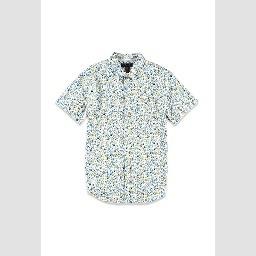

In [14]:

from prompts import products

# The text content remains the same
text_content = {
    "type": "text",
    "text": products
}

# Combine the text content with the image contents
combined_contents = [text_content] + [image_content]

headers = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer {openai.api_key}"
}

payload = {
    "model": "gpt-4-vision-preview",
    "messages": [
        {
            "role": "user",
            "content": combined_contents
        }
    ],
    "max_tokens": 4000
}
print(payload)

In [15]:
for image_file in image_files:
    # Encode the image
    base64_image = encode_image(str(image_file))

    # Make the API request
    response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)

    # Check if the response was successful
    if response.status_code == 200:
        response_json = response.json()
        try:
            content = response_json['choices'][0]['message']['content']
            print(content)

            # Save the 'content' part of the response along with the image name
            save_response_content(image_file.name, content)

            print(f"Response content saved for '{image_file.name}'.")
        except (KeyError, IndexError):
            print("Key 'choices' or 'message' is missing in the response. Full response:")
            print(response_json)
    else:
        print(f"Failed to get a successful response for '{image_file.name}'. Status code: {response.status_code}")
        print("Full response:")
        print(response.text)

{
  "product": {
    "title": "Floral Print Short-Sleeve Shirt"
  },
  "description_tags": [
    "men's clothing",
    "short-sleeve shirt",
    "floral print",
    "casual wear",
    "summer shirt",
    "button-up shirt",
    "collared shirt",
    "patterned shirt",
    "fashion"
  ]
}
Response content saved for 'image_1.jpg'.
{
  "product": {
    "title": "Floral Print Short Sleeve Shirt"
  },
  "description_tags": [
    "short sleeve shirt",
    "floral print",
    "casual wear",
    "button-up",
    "collared shirt",
    "summer fashion",
    "men's clothing",
    "patterned shirt",
    "lightweight fabric",
    "streetwear"
  ]
}
Response content saved for 'image_2.jpg'.
Failed to get a successful response for 'image_3.jpg'. Status code: 429
Full response:
{
    "error": {
        "message": "Rate limit reached for gpt-4-vision-preview in organization org-Bj4IBFQ6JFcYNum8HniPWGSw on tokens per min (TPM): Limit 10000, Used 7606, Requested 4324. Please try again in 11.58s. Visit htt

In [16]:
pip install snowflake-connector-python


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 14.6 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.7
    Uninstalling urllib3-2.0.7:
      Successfully uninstalled urllib3-2.0.7
  Attempting uninstall: platformdirs
    Found existing installation: platformdirs 4.0.0
    Uninstalling platformdirs-4.0.0:
      Successfully uninstalled platformdirs-4.0.0


### Pushing Text Tags into Snowflake Database


In [17]:
import snowflake.connector
import json

# Snowflake connection parameters
snowflake_user = 'SNOWFLAKE_USER'
snowflake_password = 'SNOWFLAKE_PASSWORD'
snowflake_account = 'ACCOUNT_IDENTIFIER'
snowflake_database = 'DATABASE'
snowflake_schema = 'public'

# Path to the JSON file
json_file_path = 'fashion_responses.json'

# Read JSON data from file
with open(json_file_path, 'r') as file:
    json_data = json.load(file)

# Snowflake connection
conn = snowflake.connector.connect(
    user=snowflake_user,
    password=snowflake_password,
    account=snowflake_account,
    database=snowflake_database,
    schema=snowflake_schema
)

cursor = conn.cursor()

for product_data in json_data:
    response_content_str = product_data.get('response_content', '{}')
    response_content = json.loads(response_content_str) if response_content_str else {}

    # Extract product information
    product_title = response_content.get('product', {}).get('title', '')
    product_description = response_content.get('product', {}).get('description', '')
    description_tags = response_content.get('description_tags', [])
    description_tags = ', '.join(description_tags)

    cursor.execute("""
        INSERT INTO product_tags (product_title, product_description, description_tags)
        VALUES (%s, %s, %s)
    """, (
        product_title,
        product_description,
        description_tags
    ))

    conn.commit()

    print("Data inserted successfully.")

# Close the cursor and connection
cursor.close()
conn.close()

Data inserted successfully.
Data inserted successfully.
Data inserted successfully.
Data inserted successfully.
